# Sportsbook Evaluation
This notebook will pull historical line data and game outcomes from covers.com and create a calibration curve which we can use to evaluate how effective sportsbooks are at setting betting lines for nhl games. We will then use this data to determine the accuracy of our own model that we create.

The code in this notebook will accomplish the following:
1. Get a list of dates that NHL games were played in the 2018/2019 season
2. For every game in the 2018/2019 season we will pull the betting lines and result of the game. We will use this season as it was the last full season played that wasn't shortened due to COVID.
3. Determine how accurate sportsbooks were at predicting the winner of games over the whole season through the use of a calibration curve.

In [1]:
from bs4 import BeautifulSoup
import datetime as dt
import matplotlib.pyplot as plt
import os
import pickle
from sklearn.calibration import calibration_curve
from sklearn.metrics import accuracy_score, brier_score_loss
import requests
import re
import sys
%matplotlib inline


## Remove Duplicates
This function will come in handy later. All it does is take a list and removes any duplicate values from that list. Example [cat,dog,duck,dog] will return [cat,dog,duck].

In [2]:
def remove_duplicates(x):
    """
    takes a list and removes duplicates from that list
    ...
    Parameters
    ----------
    x: list
        list from which duplicates will be removed
    Returns
    -------
    list
        list with duplicates removed
    """
    return list(dict.fromkeys(x))

## Pull NHL Betting Line Data
We will get our data from covers.com and hockey-reference.com. 

First we want a list of every date an NHL regular season game was played in the season specified. The list will contain datetime objects which each datetime object representing a date on which at least 1 nhl regular season game was played.

We will use the requests library in order to get this data. The below function will scrape hockey-reference.com for this data and return a list of dates for the specified season.

In [4]:
def get_nhl_dates(season):
    """
    returns a list of all dates NHL games were played in the specified season
    ...
    Parameters
    ----------
    season: int
        the two years of the season that nhl dates will be retrieved for (ex. 20192020)
    Returns
    -------
    list[dt.datetime]
        a list of datetime objects
    """
    # Determine the two years that NHL games were played for that season
    year1 = int(str(season)[:4])
    year2 = int(str(season)[4:])

    # Form the url and get response from hockey-reference.com
    url = f'https://www.hockey-reference.com/leagues/NHL_{year2}_games.html'
    resp = requests.get(url)

    # Find all the days games were played for year1 and year 2.
    days1 = re.findall(f'html">({year1}.*?)</a></th>', resp.text)
    days2 = re.findall(f'html">({year2}.*?)</a></th>', resp.text)
    days = days1 + days2

    # Remove duplicates and convert strings to datetime
    days = remove_duplicates(days)
    dates = [dt.datetime.strptime(d, '%Y-%m-%d') for d in days]

    print(f'Number of days NHL regular season played in {season}: ', len(dates))
    return dates

Lets run the function for the 2018/2019 season

In [5]:
#%% get dates that nhl games were played on in the 2018/2019 season
dates = get_nhl_dates(20182019)
print(dates[:10]) #show first 10 dates

Number of days NHL regular season played in 20182019:  223
[datetime.datetime(2018, 10, 3, 0, 0), datetime.datetime(2018, 10, 4, 0, 0), datetime.datetime(2018, 10, 5, 0, 0), datetime.datetime(2018, 10, 6, 0, 0), datetime.datetime(2018, 10, 7, 0, 0), datetime.datetime(2018, 10, 8, 0, 0), datetime.datetime(2018, 10, 9, 0, 0), datetime.datetime(2018, 10, 10, 0, 0), datetime.datetime(2018, 10, 11, 0, 0), datetime.datetime(2018, 10, 13, 0, 0)]


Now we will write a function that will scrape covers.com for the sportsbook data we need. It will take a date and return a list of dictionaries. Each dictionary item represents 1 game played on that date. The data that will be stored in the dictionaries will be as follows:

- date
- a numeric game id for that game
- home team
- away team
- home money line in american odds (ex. -110 means if you need to bet 110 to win 100 while +120 means if you bet 100 you win 120)
- goals scored by the home team
- goals scored by the away team

In [6]:
def nhl_games_date(date):
    """
    creates a list of NhlGame dictionaries for all games played on the date provided
    ...
    Parameters
    ----------
    date: dt.datetime
        datetime object for which we want to
    Returns
    -------
    list[NhlGame]
        a list of NhlGame objects
    """
    games = []

    # retrieve the covers.com webpage for the date provided
    date = date.strftime('%Y-%m-%d')
    url = f'https://www.covers.com/sports/nhl/matchups?selectedDate={date}'
    resp = requests.get(url)

    # parse the page, and retrieve all the game boxes on the page
    scraped_games = BeautifulSoup(resp.text, features='html.parser').findAll('div', {'class': 'cmg_matchup_game_box'})

    # iterate through all the game boxes and retrieve required information for NhlGame object
    for g in scraped_games:
        game_id = g['data-event-id'] # game_id
        h_abv = g['data-home-team-shortname-search'] # home_team
        a_abv = g['data-away-team-shortname-search'] # away_team
        h_ml = g['data-game-odd'] # home moneyline

        try:
            h_score = g.find('div', {'class': 'cmg_matchup_list_score_home'}).get_text(strip=True) # home score
            a_score = g.find('div', {'class': 'cmg_matchup_list_score_away'}).get_text(strip=True) # away score
        except:  # If a score cannot be found leave as blank
            h_score = ''
            a_score = ''

        game = {'date':date, 'game_id':game_id, 'home_team':h_abv,
                'away_team':a_abv, 'home_ml':h_ml, 'home_score':h_score,
                'away_score':a_score}

        games.append(game)

    return games

now we will use our "dates" list and the above function in order to pull data for all dates in our dates list

In [7]:
# intialize list to hold our data
games = []

# run a loop to get data for every date in dates
for date in dates:
    games += nhl_games_date(date)

# check length of games
print('There are '+ str(len(games)) + ' games in our list\n')

# print an entry
print(games[0])

There are 1358 games in our list

{'date': '2018-10-03', 'game_id': '121530', 'home_team': 'TOR', 'away_team': 'MON', 'home_ml': '-240', 'home_score': '3', 'away_score': '2'}


Great! We now have a database of every game in the 2018/2019 season telling us the betting line and score.

## Betting Lines and Expected Value
To understand the calibration curve we are about to create we first need to understand some betting principles.

### Coin Flipping Odds
Lets say a friend offers you a bet. He flips a coin, if it lands on heads you pay him 10 dollars if it lands on tails he will pay you 10 dollars (even odds). Should you take this bet? You will not be surprised to learn that the answer to this is it does not matter. Since there is an even chance of the coin landing on heads or tails and you friend is offering you even odds this is a 0 expected value (EV) bet. You will lose some bets, you will win some bets but over many bets you will come out even.

Scenario 2. Lets say this time your friend says if it lands on heads I will give you 15 dollars and if it lands on tails you only have to give me 10. You are betting 10 to potentially win 15 which would be equivalent to a +150 moneyline bet. Should you take this bet? The obvious answer is yes. Since there is a 50% chance of the coin landing on heads but your friend is offering you better than 50% odds this is a positive EV bet. You will lose some bets you will win some bets but over many bets you will make money.

Scenario 3. This time your friend says if it lands on heads I will give you 10 dollars if it lands on tails you owe me 15. You are betting 15 to potentially win 10 which would be equivalent to a -150 moenyline bet. Should you take this bet? The obvious answer is no. Since there is a 50% chance of the coin landing on heads but your friend is offering you worse than 50% odds this is a negative EV bet. You will lose some bets you will win some bets but over many bets you will lose money

### Sports Betting
So how does this apply to sports betting? Sports betting is betting on a coin flip however the coin is not evenly weighted. Your job as a bettor is to determine the true odds and which side is the positive EV bet.

Imagine the Flames are playing the Oilers tonight. The sportsbook is offering the Flames at -200 and the Oilers at +190 which side do you bet? The process to determine this is as follows:

1. Convert the money line odds to percentages
    -200 odds is equivalent to the sportsbook saying they think the Flames have a 66% chance of winning
    +190 odds is equivalent to the sportsbook saying they think the Oilers have a 33% chance of winning
2. Run your own analysis to determine what percent chance you think each team has of winning. Typically you would use some sort of model to determine this. We are going to build a machine learning model that will calculate these percentages for us. Lets say you run your model and come up with the following
    Flames will win 60% of the time
    Oilers will win 40% of the time
3. Now which side do you bet? 
    - Based on the odds the sportsbook thinks the Flames win 66% you think they win only 60% therefore betting the Flames would be negative EV.
    - Also based on the odds the sportsbook thinks the Oilers will win 33% of the time however you think they will actually win 40% of the time therefore betting the Oilers is positive EV.

Even though the Flames are more likely to win the game betting them is negative EV and you would lose money over time. Betting the Oilers is a positive EV bet even though you will lose this bet more often than not.

The way sportsbooks make money is that they try to set the betting line so both sides of the bet are negative EV. This is due to a comission they bake into the line. If Sportsbook determines that a teams true odds are -200 they will actually offer the bet at say -220 this way they can make both sides of the bet negative EV ensuring they always make a profit.

The goal of any sports betting model is to identify bets where the sportsbook odds do not reflect a teams true odds of winning.

## Calibration Curve
Now that we have some betting theory out of the way lets start creating a calibration curve. This first function will take our game database list and calculate the sportsbooks accuracy in predicting games. If the predicted favourite actually ends up winning the game then that is counted as a correct prediction. If the underdog wins that is an incorrect prediction.

The function will take the list of games we have and return 4 things for us:
1. Accuracy - will be a single number telling us what percentage of predicted favourites won the game
2. Outcome - a list of booleans. True if the home team won the game, False if the away team won
3. Predictions - a list of booleans. True if the sportsbook had the home team favoured, False if the away team was favoured
4. Probabilities - the probability of the home team winning based on the moneyline odds. (ex. -200 = 66%)

In [8]:
def sportsbook_accuracy(game_data):
    """
    calculates the accuracy score of the sportsbooks for the provided games
    ...
    Parameters
    ----------
    game_data: List[Dict]
        list of NhlGame objects for which we want to calculate the accuracy score for
    Returns
    -------
    accuracy: float
        the accuracy of the sportsbooks predictions
    outcomes: List[Boolean]
        True if the home team wins
    predictions: List[Boolean]
        True if the sportsbook had the home team favoured
    probabilities: List[float]
        the implied probability of the home team winning based on the moneyline odds
    """
    outcomes = []  # The actual outcome of the game. True if the home team wins
    predictions = []  # The sportsbook's "prediction". True if the home team was favoured.
    probabilities = []  # The implied probabilities determined from the moneyline odds

    for d in game_data:
        moneyline = int(d['home_ml'])
        home_score = int(d['home_score'])
        away_score = int(d['away_score'])

        if moneyline == 100:
            # We will exclude tossups for the calibration curve
            continue

        # Convert moneyline odds to their implied probabilities
        if moneyline < 0:
            probabilities.append(moneyline / (moneyline - 100))
        elif moneyline > 100:
            probabilities.append(100 / (moneyline + 100))

        outcomes.append(home_score > away_score)
        predictions.append(moneyline < 0)

    accuracy = 100 * accuracy_score(outcomes, predictions)

    return accuracy, outcomes, predictions, probabilities

In [21]:
accuracy, outcomes, predictions, probabilities = sportsbook_accuracy(games)
print('Accuracy')
print('Sportsbooks accuracy is ' + str(accuracy))
print('Outcomes')
print(outcomes[:10])
print('Predictions')
print(predictions[:10])
print('Probabilities')
print(probabilities[:10])

#%% pickle results
with open('/Users/patrickpetanca/projects/nhl_analysis/data/baseline.pkl', 'wb') as f:
    pickle.dump((outcomes, predictions, probabilities), f)

Accuracy
Sportsbooks accuracy is 57.564296520423596
Outcomes
[True, True, True, False, True, False, False, False, False, True]
Predictions
[True, True, False, True, True, True, False, False, False, True]
Probabilities
[0.7058823529411765, 0.5348837209302325, 0.46511627906976744, 0.6491228070175439, 0.6226415094339622, 0.6296296296296297, 0.46511627906976744, 0.39215686274509803, 0.46511627906976744, 0.6428571428571429]


We can see from the above that the sportbook correctly predicted the winner of the game 57.56% of the time. We can also compare our outcome and predictions list. If the corresponding elements in the two lists are both True or Both False the sportsbook correctly predicted the winner. If they are different they were incorrect.

Now we have all the data we need to create our calibration curve.

In [19]:
def cal_curve(data, bins):
    """
    creates a calibration curve. X axis is the implied probability while the y axis is the percentage
    of time that prediction was correct
    ...
    Parameters
    ----------
    data: List[Tuple[List[Boolean], List[Boolean], List[Float], str]]
        the data that will be used to create the calibration curve. (Outcomes, Predictions, Probabilities, Name)
    Returns
    -------
    accuracy: float
        the accuracy of the sportsbooks predictions
    outcomes: List[Boolean]
        True if the home team wins
    predictions: List[Boolean]
        True if the sportsbook had the home team favoured
    probabilities: List[float]
        the implied probability of the home team winning based on the moneyline odds
    """

    fig = plt.figure(1, figsize=(12, 8))
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((3, 1), (2, 0))

    ax1.plot([0, 1], [0, 1], "k:", label="Perfectly Calibrated")

    for y_test, y_pred, y_proba, name in data:
        brier = brier_score_loss(y_test, y_proba)
        print("{}\tAccuracy:{:.4f}\t Brier Loss: {:.4f}".format(
            name, accuracy_score(y_test, y_pred), brier))
        fraction_of_positives, mean_predicted_value = calibration_curve(y_test, y_proba, n_bins=bins)

        ax1.plot(mean_predicted_value, fraction_of_positives, label="%s (%1.4f)" % (name, brier))
        ax2.hist(y_proba, range=(0, 1), bins=bins, label=name, histtype="step", lw=2)

    ax1.set_ylabel("Fraction of positives")
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc="lower right")
    ax1.set_title('Calibration plots  (reliability curve)')

    ax2.set_xlabel("Mean predicted value")
    ax2.set_ylabel("Count")
    ax2.legend(loc="lower right")

    plt.tight_layout()
    my_path = '/Users/patrickpetanca/projects/nhl_analysis'
    fig.savefig(my_path + '/results/sb_evaluation.png')

Sportsbook	Accuracy:0.5756	 Brier Loss: 0.2427


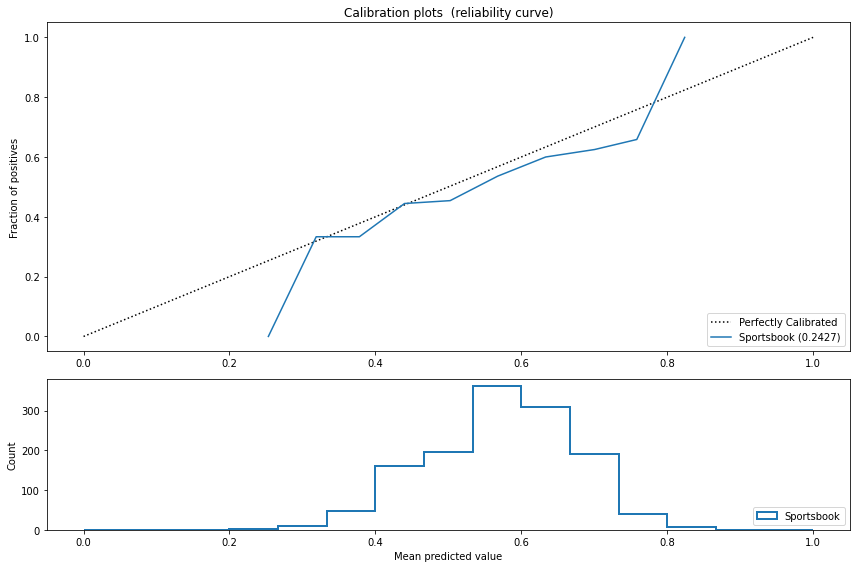

In [20]:
# code to create calibration curve
data = [(outcomes, predictions, probabilities, 'Sportsbook')]
cal_curve(data,15)

The x-axis on the above chart tells us what the sportsbook predicted probability of the home team winning a game was. While the y-axis tells us what percentage of time the home team actulaly ended up winning. For a perfectly calibrated model these two values will be equal (If the model predicts a team will win 60% of the time they should actually win approximately 60% of the team). If they do not the model is not very useful.

The histogram below the charts just shows our sample size for each probability bucket.

We can see that sportsbooks are actually quite good at predicting outcomes of games. The blue line follows the "Perfectly Calibrated" line quite closely. You can see that the blue line is shifted slightly below a perfectly calibrated model this is due to the comission (or juice) that the sportsbooks build into their lines.

The predictions weren't very good for large underdogs and large favourites. But this is likely just due to a small sample size and if we had more data it would likely be closer to the "Perfectly Calibrated" line.

### Brier Score
We can use the Brier score to quantify the effectiveness of a Sportsbooks predictions. The Brier score is a model evaluation  metric used to how well your model is at predicted probabilities of events happening. All a Brier score does is measure the distance between the blue line above and the "Perfectly Calibrated" line. The Brier score takes a value between 0 and 1 with zero being a perfect model and 1 being a terrible model. Note that a model with a perfect Brier score of 0 doesn't mean that it correctly predicts the outcome of every game rather it correctly predicts the probability of a team winning over time.

We are going to build our own model and compare it's Brier score to the 0.2427 value calculated above to determine if we can buld a model that beats the books.